In [175]:
#########
# BASIC #
#########
import os
import sys
import platform
import warnings
from datetime import datetime
from collections import Counter
import calendar
from tqdm.notebook import tqdm_notebook

#############
# LOAD DATA #
#############
import numpy as np
import pandas as pd

#############################
# EXPLORATORY DATA ANALYSIS #
#############################
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

######################
# DATA PREPROCESSING #
######################
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
## NATURAL LANGUAGE PROCESSING 
from konlpy.tag import Komoran
from gensim.models import Word2Vec

In [176]:
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.4f}'.format
# plt.style.use('ggplot')
if platform.platform().split('-')[0] == 'Windows':
    mpl.rcParams['font.family'] = 'Malgun Gothic' # Windows에서는 한글이 나오게 하기 위해서
else: # macOS라고 가정
    mpl.rcParams['font.family'] = 'AppleGothic' # mac에서는 한글이 나오게 하기 위해서

mpl.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

In [177]:
data = dict()

In [178]:
data['train'] = pd.read_excel(r'../../data/01_제공데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx',
                       header=1,
                       names=['방송일시', '노출(분)', '마더코드', '상품코드',
                              '상품명', '상품군', '판매단가', '취급액'],
                       thousands=',',
                       )
data['train'].index = pd.to_datetime(data['train']['방송일시'])
data['train'] = data['train'].drop('방송일시',axis=1)
data['train'] = data['train']['2019']
data['train']

,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
방송일시,,,,,,,
2019-01-01 06:00:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0000
2019-01-01 06:00:00,nan,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0000
2019-01-01 06:20:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0000
2019-01-01 06:20:00,nan,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0000
2019-01-01 06:40:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0000
...,...,...,...,...,...,...,...
2019-12-31 23:20:00,nan,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,1664000.0000
2019-12-31 23:40:00,20.0000,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,9149000.0000
2019-12-31 23:40:00,nan,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,15282000.0000


In [179]:
data['train']['연'] = data['train'].index.map(lambda x: x.year)
data['train']['월'] = data['train'].index.map(lambda x: x.month)
data['train']['주'] = data['train'].index.map(lambda x: x.week)
data['train']['일'] = data['train'].index.map(lambda x: x.day)
data['train']['시'] = data['train'].index.map(lambda x: x.hour)
data['train']['분'] = data['train'].index.map(lambda x: x.minute)
data['train']['요일'] = data['train'].index.map(lambda x: calendar.day_abbr[x.weekday()])

In [180]:
data['train']['day'] = data['train'].index.map(lambda x: str(x.year) + str(x.month).zfill(2) + str(x.day).zfill(2))

In [181]:
#for date in data['train'].day.unique():
np.array([data['train'][data['train'].day==date].drop_duplicates(['상품명']).shape[0] for date in data['train'].day.unique()]).mean()

35.679452054794524

In [110]:
# 노출시간이 비어있을땐 앞을 보면 됨
# data['train'] = data['train'].fillna(method='ffill')

In [182]:
def re_sub(series: pd.Series) -> pd.Series:
    series = series.str.replace(pat=r'[ㄱ-ㅎ]', repl=r'', regex=True)  # ㅋ 제거용
    series = series.str.replace(pat=r'[^\w\s]', repl=r'', regex=True)  # 특수문자 제거
    series = series.str.replace(pat=r'[ ]{2,}', repl=r' ', regex=True)  # 공백 제거
    series = series.str.replace(pat=r'[\u3000]+', repl=r'', regex=True)  # u3000 제거
    return series

In [183]:
train = data['train'][['상품명', '상품군']].copy()
train.상품명 = re_sub(train.상품명)

In [184]:
prod_names = (train[train.상품군 != '무형'].상품명 + ' ' + train[train.상품군 != '무형'].상품군).values # len(prod_names) > 1692 (무형 빼고)

In [185]:
komoran = Komoran(userdic='../../data/04_추가데이터/user_dict_0913.txt')
print(komoran.pos("KOMORAN은 한국어 형태소 분석기입니다."))

[('KOMORAN', 'SL'), ('은', 'JX'), ('한국어', 'NNP'), ('형태소', 'NNP'), ('분석기', 'NNG'), ('이', 'VCP'), ('ㅂ니다', 'EF'), ('.', 'SF')]


In [186]:
naive_tokens = list(map(komoran.pos, prod_names))

In [187]:
def morph_filter(lst):
    return list(map(lambda x: x[0], filter(lambda x: (x[1] in usable_morphs), lst)))

usable_morphs = ['NNG', 'NNP', 'NP', 'NR'] #+ ['SL', 'SN']
naive_tokens = list(map(morph_filter, naive_tokens))

In [188]:
exclude_words = ['종', '인용']
def exclude(lst):
    return list(filter(lambda x: x not in exclude_words, lst))
processed_tokens = list(map(exclude, naive_tokens))

In [189]:
to_string = list(map(lambda x: ' '.join(x[:-1]), processed_tokens))

In [190]:
train = data['train'][data['train'].상품군 != '무형']

In [191]:
train['unique_name'] = to_string

### Plot

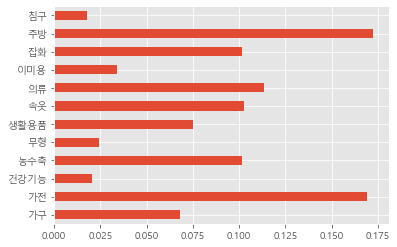

In [121]:
(data['train']['상품군'].value_counts().sort_index() / len(data['train']['상품군'])).plot(kind='barh')
plt.show()

In [127]:
train['indice'] = train.index

In [128]:
unique_time = train.drop_duplicates(subset='indice')

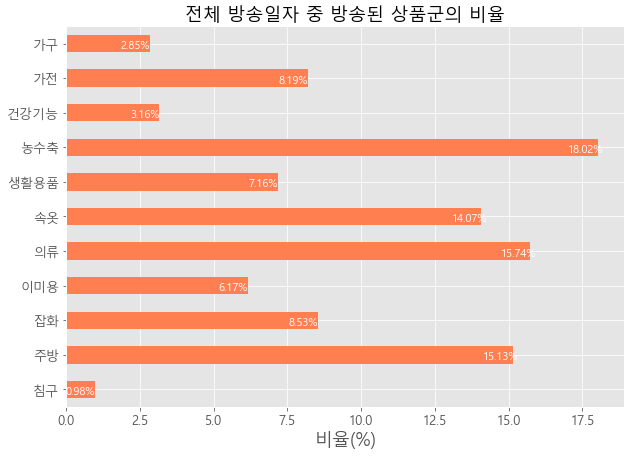

In [129]:
ax = (unique_time['상품군'].value_counts().sort_index() / len(unique_time['상품군']) * 100).plot(kind='barh', figsize=(10,7),
                                        color="coral", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("전체 방송일자 중 방송된 상품군의 비율", fontsize=18)
ax.set_xlabel("비율(%)", fontsize=18);
#ax.set_xticks([0, 5, 10, 15, 20])

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()-1, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=11,
color='white')

# invert for largest on top 
ax.invert_yaxis()

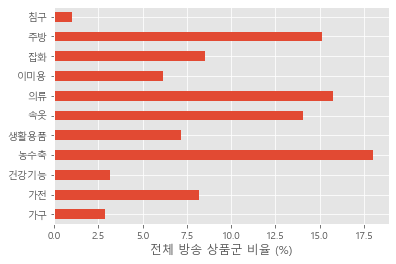

In [130]:
(unique_time['상품군'].value_counts().sort_index() / len(unique_time['상품군']) * 100).plot(kind='barh')
plt.xlabel('전체 방송 상품군 비율 (%)')
plt.show()

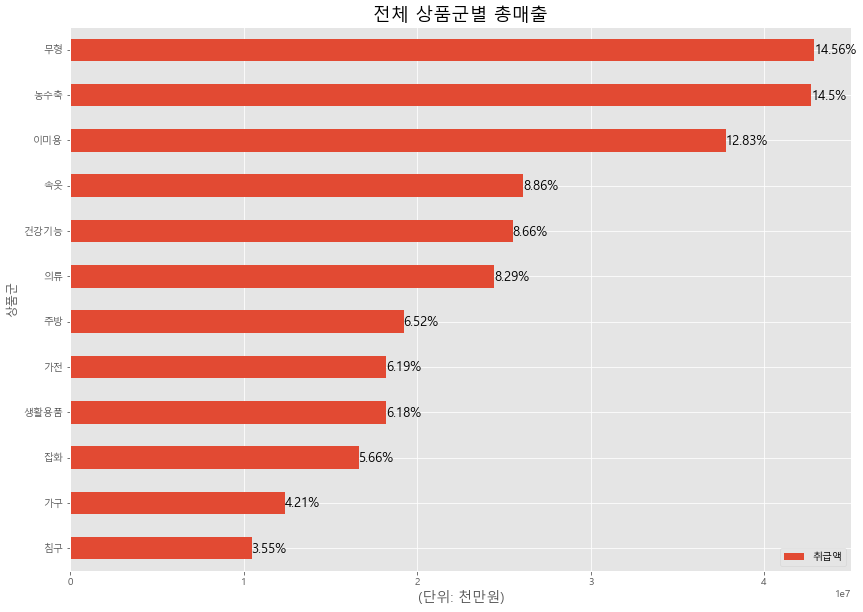

In [131]:
ax = data['train'].pivot_table(values=['취급액'],
                   index=['상품군'],
                   aggfunc='mean').sort_values(by='취급액',ascending=True).plot(kind='barh', figsize=(14, 10))
ax.set_alpha(0.8)
ax.set_title("전체 상품군별 총매출", fontsize=18)
ax.set_xlabel("(단위: 천만원)", fontsize=14)

totals = []
for i in ax.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_width() + 3, i.get_y()+.15, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=13, color='black')

In [132]:
import plotly.express as px

In [133]:
df = train.pivot_table(values=['취급액'],
                   index=['상품군'],
                   aggfunc='mean').sort_values(by='취급액',ascending=True)

In [134]:
df.취급액

상품군
침구     10454844.5441
가구     12391816.3734
잡화     16673807.2475
생활용품   18220389.9896
가전     18234110.2022
주방     19216153.1818
의류     24432825.1152
건강기능   25505397.4684
속옷     26097666.2414
이미용    37795110.3448
농수축    42724572.8630
Name: 취급액, dtype: float64

In [135]:
fig = px.pie(df, values='취급액', names=df.index, title='상품군의 총 취급액 비율', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [165]:
train.groupby(['상품군', 'unique_name']).sum()

노출(분)     마더코드     상품코드     판매단가  \
상품군 unique_name                                                            
가구  뉴 벨라홈 리클라이닝 소파                   113.6833   601380  1204758   534000   
    레스토닉 블루투스 LED 서랍 침대 슈퍼싱글         180.0000   905346  1816377  5691000   
    레스토닉 블루투스 LED 서랍 침대 퀸            180.0000   905346  1816395  6141000   
    레스토닉 블루투스 LED 서랍 침대 킹            180.0000   905346  1816413  6591000   
    무 보루네오 원목 베드룸 세트 프레임 매트리스 화장대 협탁  60.0000   200408   401396  2898000   
...                                       ...      ...      ...      ...   
침구  효재 자수 광목 침구 세트 퀸                 300.0000  1002000  2006760  1490000   
    효재 자수 광목 침구 세트 킹                 300.0000  1002000  2006770  1690000   
    효재 화원 자수 광목워싱 침구 세트 슈퍼싱글         115.2000   601200  1204071   744000   
    효재 화원 자수 광목워싱 침구 세트 퀸            115.2000   601200  1204083   864000   
    효재 화원 자수 광목워싱 침구 세트 킹            115.2000   601200  1204095   984000   

                                                취급액      연   월    주    일    시  \
상품군 unique_name                                                                 
가구  뉴 벨라홈 리클라이닝 소파                    89860000.0000  12114  54  228  123    6   
    레스토닉 블루투스 LED 서랍 침대 슈퍼싱글         101834000.0000  18171  99  270  202  170   
    레스토닉 블루투스 LED 서랍 침대 퀸            126635000.0000  18171  99  270  202  170   
    레스토닉 블루투스 LED 서랍 침대 킹            155678000.0000  18171  99  270  202  170   
    무 보루네오 원목 베드룸 세트 프레임 매트리스 화장대 협탁  24869000.0000   4038  18   76   44   46   
...                                             ...    ...  ..  ...  ...  ...   
침구  효재 자수 광목 침구 세트 퀸                 115054000.0000  20190  54  218  150  122   
    효재 자수 광목 침구 세트 킹                 189683000.0000  20190  54  218  150  122   
    효재 화원 자수 광목워싱 침구 세트 슈퍼싱글          16767000.0000  12114  45  195  153   42   
    효재 화원 자수 광목워싱 침구 세트 퀸             29617000.0000  12114  45  195  153   42   
    효재 화원 자수 광목워싱 침구 세트 킹             66521000.0000  12114  45  195  153   42   

                                        분  
상품군 unique_name                            
가구  뉴 벨라홈 리클라이닝 소파                    120  
    레스토닉 블루투스 LED 서랍 침대 슈퍼싱글          180  
    레스토닉 블루투스 LED 서랍 침대 퀸             180  
    레스토닉 블루투스 LED 서랍 침대 킹             180  
    무 보루네오 원목 베드룸 세트 프레임 매트리스 화장대 협탁   30  
...                                   ...  
침구  효재 자수 광목 침구 세트 퀸                  150  
    효재 자수 광목 침구 세트 킹                  150  
    효재 화원 자수 광목워싱 침구 세트 슈퍼싱글          120  
    효재 화원 자수 광목워싱 침구 세트 퀸             120  
    효재 화원 자수 광목워싱 침구 세트 킹             120  

[1488 rows x 11 columns]

In [174]:
train

,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,연,월,주,일,시,분,요일,day,unique_name,indice
방송일시,,,,,,,,,,,,,,,,,
2019-01-01 06:00:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0000,2019,1,1,1,6,0,Tue,20190101,테이트 남성 셀린니트,2019-01-01 06:00:00
2019-01-01 06:00:00,20.0000,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0000,2019,1,1,1,6,0,Tue,20190101,테이트 여성 셀린니트,2019-01-01 06:00:00
2019-01-01 06:20:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0000,2019,1,1,1,6,20,Tue,20190101,테이트 남성 셀린니트,2019-01-01 06:20:00
2019-01-01 06:20:00,20.0000,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0000,2019,1,1,1,6,20,Tue,20190101,테이트 여성 셀린니트,2019-01-01 06:20:00
2019-01-01 06:40:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0000,2019,1,1,1,6,40,Tue,20190101,테이트 남성 셀린니트,2019-01-01 06:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 23:20:00,20.0000,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,1664000.0000,2019,12,1,31,23,20,Tue,20191231,일시불 쿠첸 압력 밥솥,2019-12-31 23:20:00
2019-12-31 23:40:00,20.0000,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,9149000.0000,2019,12,1,31,23,40,Tue,20191231,무이자 쿠첸 압력 밥솥,2019-12-31 23:40:00
2019-12-31 23:40:00,20.0000,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,15282000.0000,2019,12,1,31,23,40,Tue,20191231,일시불 쿠첸 압력 밥솥,2019-12-31 23:40:00


In [173]:
df = train.groupby(['상품군', 'unique_name']).sum()
fig = px.pie(df, values='노출(분)', names=[x[0] for x in df.index], title='방송 시간 비율', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [136]:
import seaborn as sns

In [137]:
cat = '농수축'

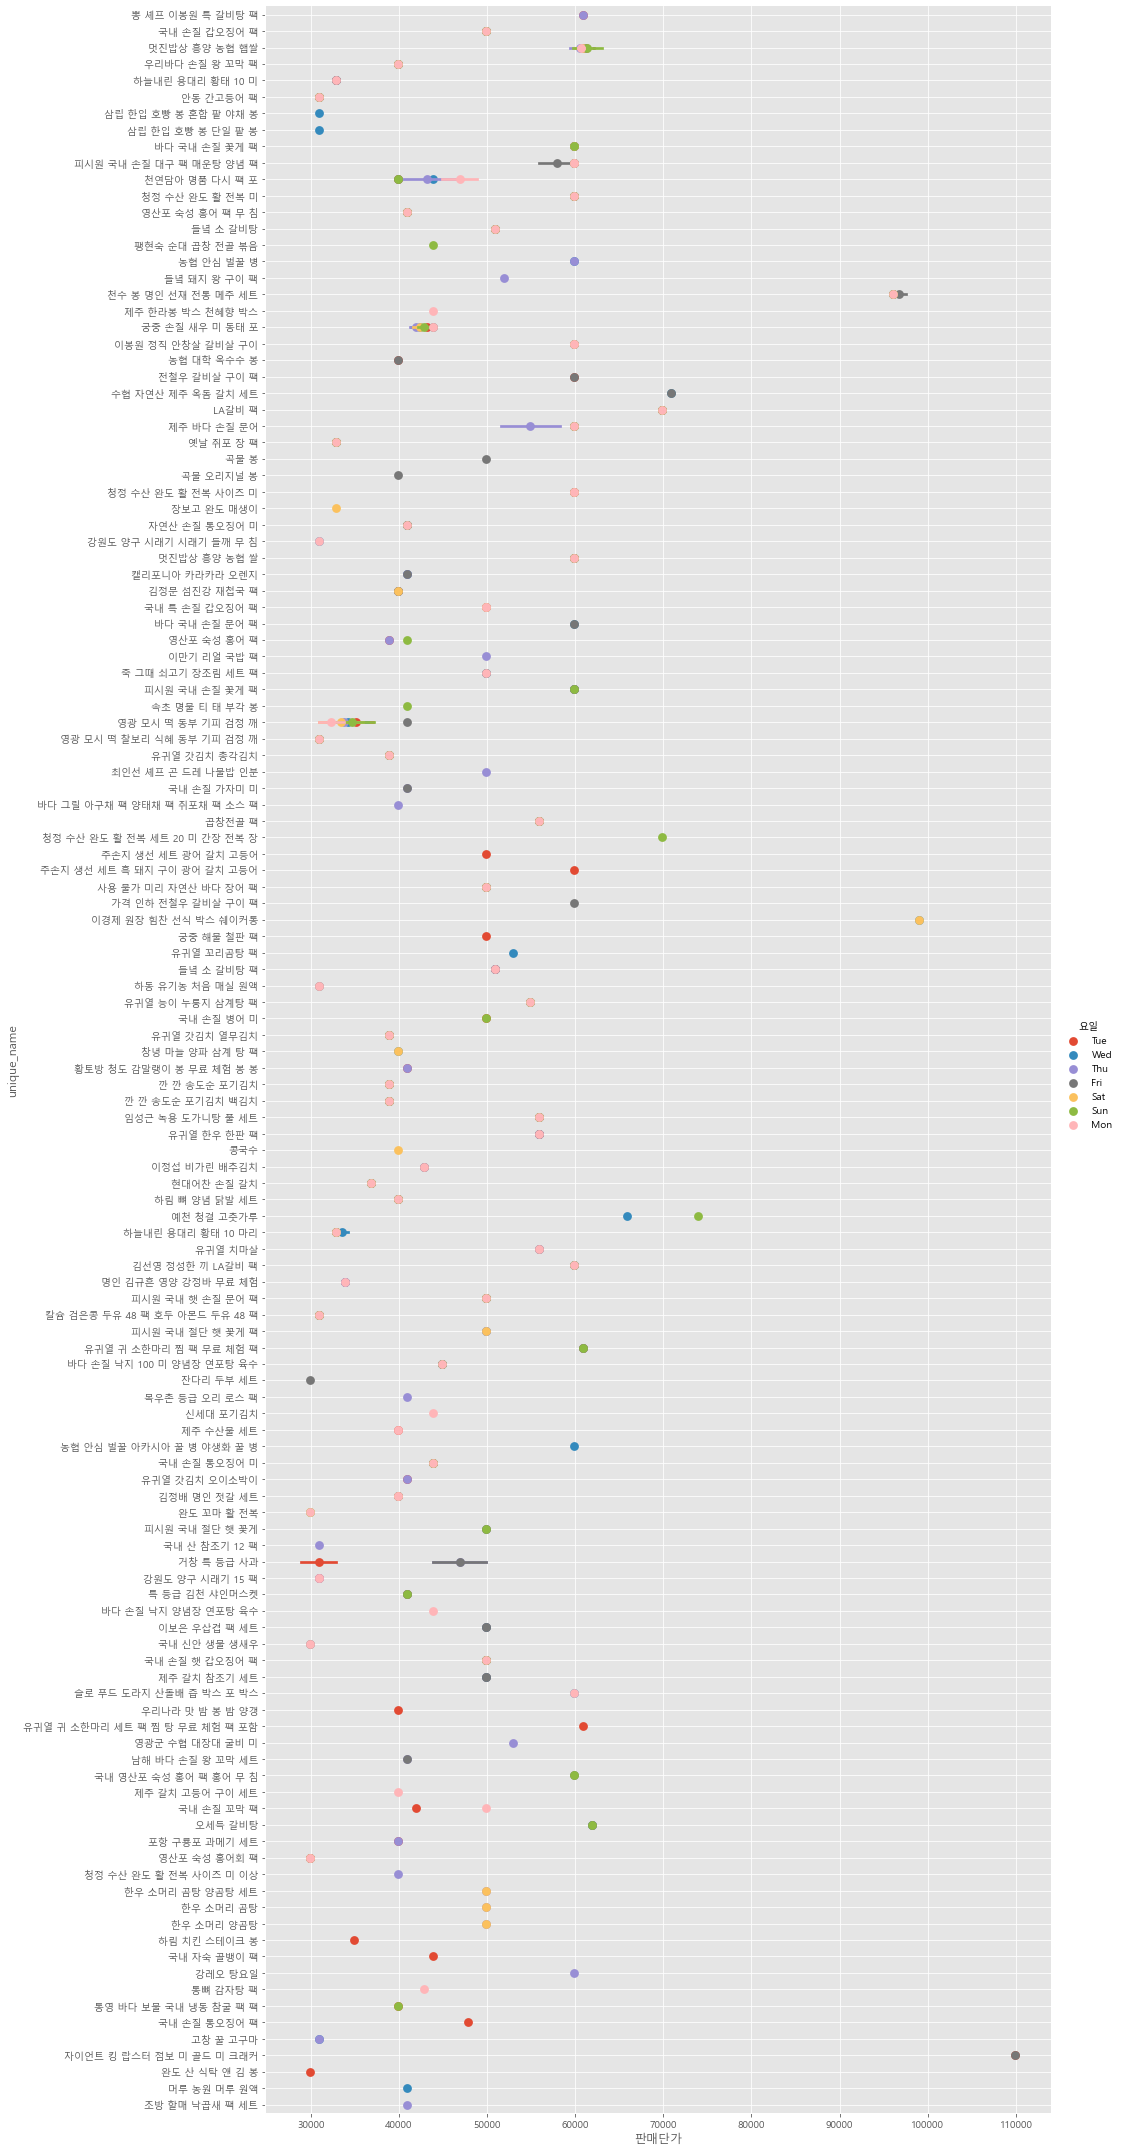

In [138]:
sns.factorplot(data=train[train.상품군==cat],
              x='판매단가', y='unique_name', size=30, aspect=.5,
                join=False, legend_out=True,
              hue='요일')
plt.grid(True)

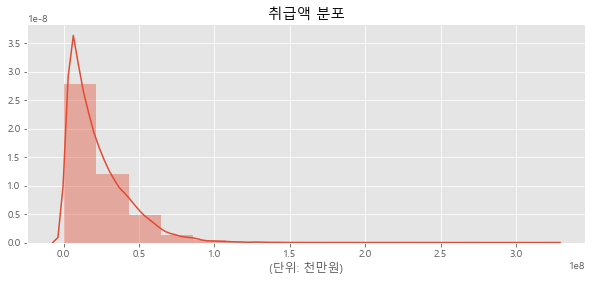

In [139]:
plt.figure(figsize=(10, 4))
sns.distplot(train['취급액'], bins=15)
plt.title("취급액 분포")
plt.xlabel('(단위: 천만원)')
sns.despine()
plt.show()

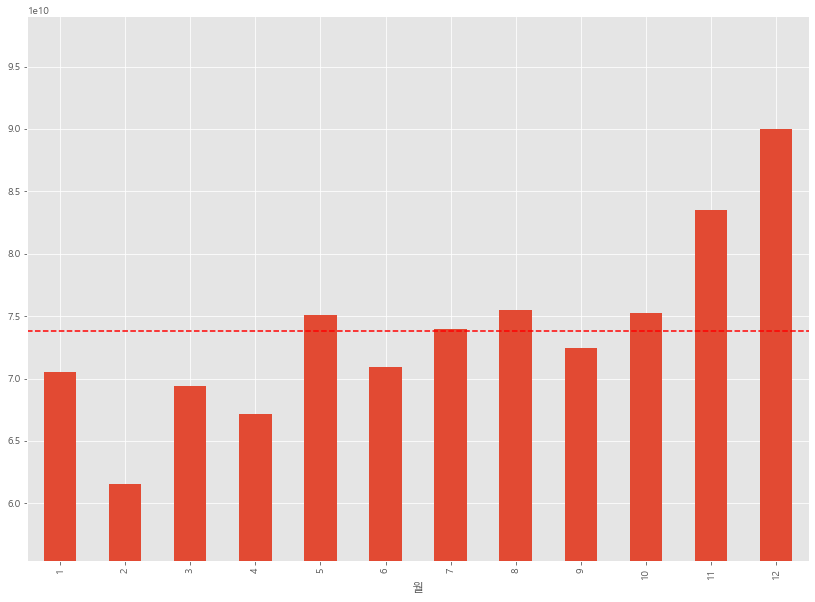

In [140]:
month_group = data['train']['2019'].groupby('월').sum()
month_group['취급액'].plot(kind='bar', figsize=(14, 10))
plt.axhline(y = np.mean(month_group.취급액), color = 'red', ls = '--')
plt.ylim(month_group['취급액'].min()*0.9, month_group['취급액'].max()*1.1)
plt.show()

In [143]:
df = data['train']['2019'].groupby('시').sum()

In [145]:
df

,노출(분),마더코드,상품코드,판매단가,취급액,연,월,주,일,분
시,,,,,,,,,,
0,36831.0667,174166154,349139800,529203600,33433642000.0000,3502965,11172,44894,26069,33720
1,29905.2833,161072056,322912317,229476200,18896150000.0000,3238476,10185,41217,24873,32150
2,1450.0000,7230791,14496300,11430400,1188668000.0000,145368,820,3394,1103,20
6,27162.8000,136664267,273943222,186866750,18106918000.0000,2747859,8774,35652,21273,29110
7,30052.3833,148774825,298257577,168940150,31881393000.0000,2990139,9924,40403,23679,29555
8,34874.4667,165176180,331181571,436474450,37114909000.0000,3319236,11307,46022,26172,32115
9,33084.2000,160834255,322401944,441570000,42683767000.0000,3234438,10683,43277,25091,31540
10,41892.5167,197158188,395253698,830498000,47904283000.0000,3963297,12733,51636,30324,39460
11,39109.8167,188321627,377425428,556712100,45024680000.0000,3787644,12350,49884,27985,36770


In [148]:
fig = px.pie(df, values='취급액', names=df.index,  title='상품군의 총 취급액 비율', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [150]:
df = data['train']['2019'].groupby('요일').sum()

In [153]:
fig = px.pie(df, values='취급액', names=df.index,  title='요일별 총 취급액 비율',
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

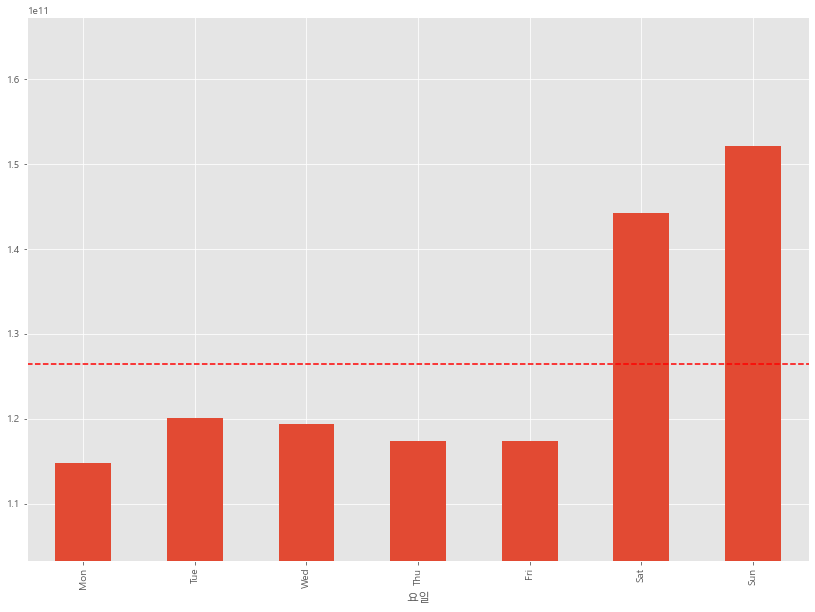

In [149]:
weekday_group = data['train']['2019'].groupby('요일').sum()
weekday_group = weekday_group.T.loc['취급액',['Mon','Tue','Wed','Thu','Fri','Sat','Sun']]
weekday_group.plot(kind='bar', figsize=(14, 10)) #0: Monday ~ 6: Sunday
plt.axhline(y = np.mean(weekday_group), color = 'red', ls = '--')
plt.ylim(weekday_group.min()*0.9, weekday_group.max()*1.1)
plt.show()

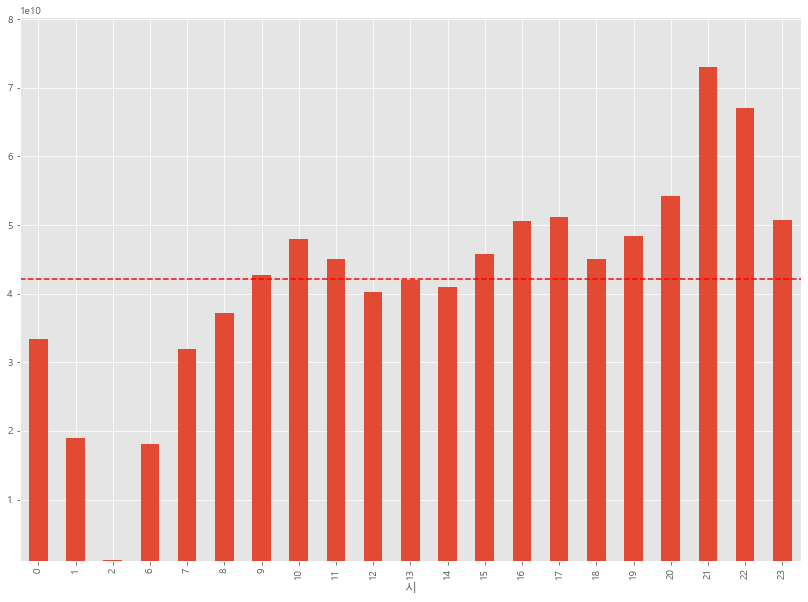

In [141]:
hour_group = data['train']['2019'].groupby('시').sum()
hour_group['취급액'].plot(kind='bar', figsize=(14, 10))
plt.axhline(y = np.mean(hour_group['취급액']), color = 'red', ls = '--')
plt.ylim(hour_group['취급액'].min()*0.9, hour_group['취급액'].max()*1.1)
plt.show()

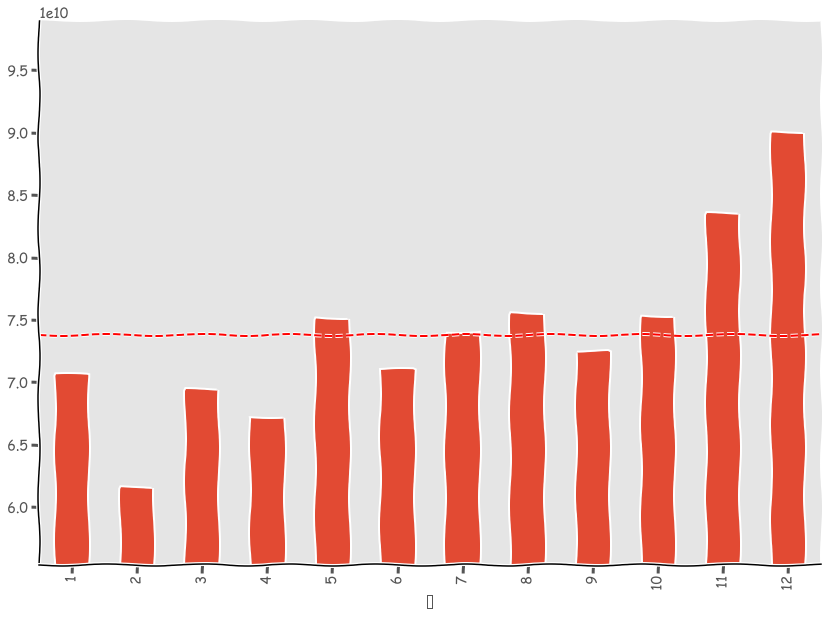

In [154]:
import matplotlib
matplotlib.font_manager._rebuild()
with plt.xkcd():
    month_group = data['train']['2019'].groupby('월').sum()
    month_group['취급액'].plot(kind='bar', figsize=(14, 10))
    plt.axhline(y = np.mean(month_group.취급액), color = 'red', ls = '--')
    sns.despine()
    plt.ylim(month_group['취급액'].min()*0.9, month_group['취급액'].max()*1.1)
    plt.show()